# Profiling and Optimising


**Optimising** is the process of making your code 'better' by some metric.
Most often, this is total runtime (how long it takes),
but can also mean things like reducing memory usage or any other way to measure the 'cost' of your code.

**Profiling** is a way of measuring your code,
to figure out what part of it you may want to to optimize.

IPython provides some tools that can make it it a bit easier to profile and optimise your code sometimes.

For more information on IPython, see [our IPyton notes](../02

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## `%timeit`

The main IPython tool we are going to use here is `%timeit`,
a magic that automates measuring how long it takes to run a snippet of code.

In [ ]:
for N in (100, 500, 1000, 2000):
    print(f"Size: {N} x {N}")
    A = np.random.random((N, N))
    %timeit A.dot(A)

Let's look at what options `%timeit` can take.

In [ ]:
%timeit?

We can save the result in an object with `%timeit -o`,
and specify to only run one group of 100 iterations.

In [ ]:
A = np.random.random((100, 100))
tr = %timeit -o -n 1 -r 100 A.dot(A)

In [ ]:
tr

In [ ]:
tr.best

In [ ]:
tr.best, tr.worst

In [ ]:
print(len(tr.all_runs))
tr.all_runs[:10]

In [ ]:
plt.hist(np.array(tr.all_runs) * 1e6)
plt.xlabel("t (µs)");

## Diffusing a wave

Our task is to optimise a 1-D diffusion algorithm,
using numpy and Cython.

Our input signal is a sawtooth wave:

$$
x_\mathrm{sawtooth}(t) = \frac{A}{2}-\frac {A}{\pi}\sum_{k=1}^{\infty}\frac {\sin (k t)}{k}
$$

In [ ]:
from scipy.signal import sawtooth

T = 8 * np.pi
t = np.linspace(0, T, 512)
x = sawtooth(t)
plt.plot(t, x)

steps = 2048

# Exercise: turning math into code



Hints:

1. when you see a sum over a variable, that should make you think of a `for` loop
2. `x(t)` can be an *array*, where `t` is an array of values, and `x` is the result of calling an 

For example, to implement 

$$
x(t) = sin(t)
$$

In [ ]:
x = np.sin(t)
plt.plot(t, x)

$$
x_\mathrm{sawtooth}(t) = \frac{A}{2}-\frac {A}{\pi}\sum_{k=1}^{\infty}\frac {\sin (k t)}{k}
$$

In [ ]:
def my_sawtooth(t, A=1, n_freqs = 100):
    # x = A/2 - ...
    x = np.ones(t.shape) * 0.5
    # A/π * sum(k=1, k=n_freqs) { sin(k t) / k }
    for k in range(1, n_freqs + 1):
        x -= np.sin(k * t) / (k * np.pi)
    return x * A


# test your sawtooth output
# it should look like similar to the above

n_list = [5, 10, 100, 1000]
fig, axes = plt.subplots(len(n_list), 1)

for ax, n_freqs in zip(axes, n_list):
    ax.plot(t, my_sawtooth(t, n_freqs=n_freqs))
    ax.set_title(f"n={n_freqs}")


We are going to diffuse the wave by evolving the heat equation:

$$
\frac{\delta x}{\delta t} = \alpha \frac{\delta^2 x}{\delta t^2}
$$

Which we can discretize for our arrays:

\begin{align}
x_{k}[i] =& \frac{1}{4} \left( 
    x_{k-1}[i-1] +
    2 x_{k-1}[i] +
    x_{k-1}[i+1]
    \right) & i \in [1, N-1] \\
x_{k}[0] =& x_{0}[0] \\
x_{k}[N] =& x_{0}[N] \\
\end{align}

In [ ]:
points = [10, 100, 10, 100, 10]

plt.bar(range(len(points)), points)
plt.text(1, 101, "1/2", size=16, ha='center')
plt.text(0, 11, "1/4", size=16, ha='center')
plt.text(2, 11, "1/4", size=16, ha='center')

In [ ]:
import time
from IPython.display import clear_output

i_list = range(len(points))
for k in range(20):
    plt.bar(range(len(points)), points)
    plt.ylim(0, 100)
    plt.title(f"k = {k}")
    plt.show()
    next_points = points.copy()
    for i in range(1, len(points) - 1):
        next_points[i] = 0.25 * points[i - 1] + 0.5 * points[i] + 0.25 * points[i + 1]
    points = next_points
    time.sleep(1)
    clear_output(wait=True)

## Pure Python

We'll start with a pure Python implementation,
to use as a reference.

Let's implement our algorithm:

Advancing our blur *one step* looks like:

\begin{align}
x_{k}[0] =& x_{0}[0] \\
x_{k}[N] =& x_{0}[N] \\
x_{k}[i] =& \frac{1}{4} \left( 
    x_{k-1}[i-1] +
    2 x_{k-1}[i] +
    x_{k-1}[i+1]
    \right) & i \in [1, N-1]
\end{align}

and we keep repeating that to get

$$
x_k \in 1...steps
$$

- What variables do we need?
- How many loops?

In [ ]:
def blur_py(x0, steps=1024):
    """Advance a Gaussian blur `steps` steps"""
    x = 1 * x0  # copy
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for k in range(steps):
        for i in range(1, len(x) - 1):
            x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
        x, x_k = x_k, x  # swap for next step
    return x

In [ ]:
y = blur_py(x, steps)
plt.plot(t, x, '--')
plt.plot(t, y);

Now we can measure how long it takes to run evolve this system:

In [22]:
ref_run = %timeit -o y = blur_py(x, steps)
t_ref = ref_run.best

times = [t_ref]
labels = ['python']

2.99 s ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So it takes a few seconds.
We can also see how it changes with different times and resolutions.

## Vectorizing with numpy

We can vectorize the inner loop with a single numpy operation:

In [23]:
import numpy as np


def blur_np(x, steps=1024):
    x = 1 * x
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for _ in range(steps):
        x_k[1:-1] = 0.25 * (x[0:-2] + 2 * x[1:-1] + x[2:])
        x, x_k = x_k, x
    return x

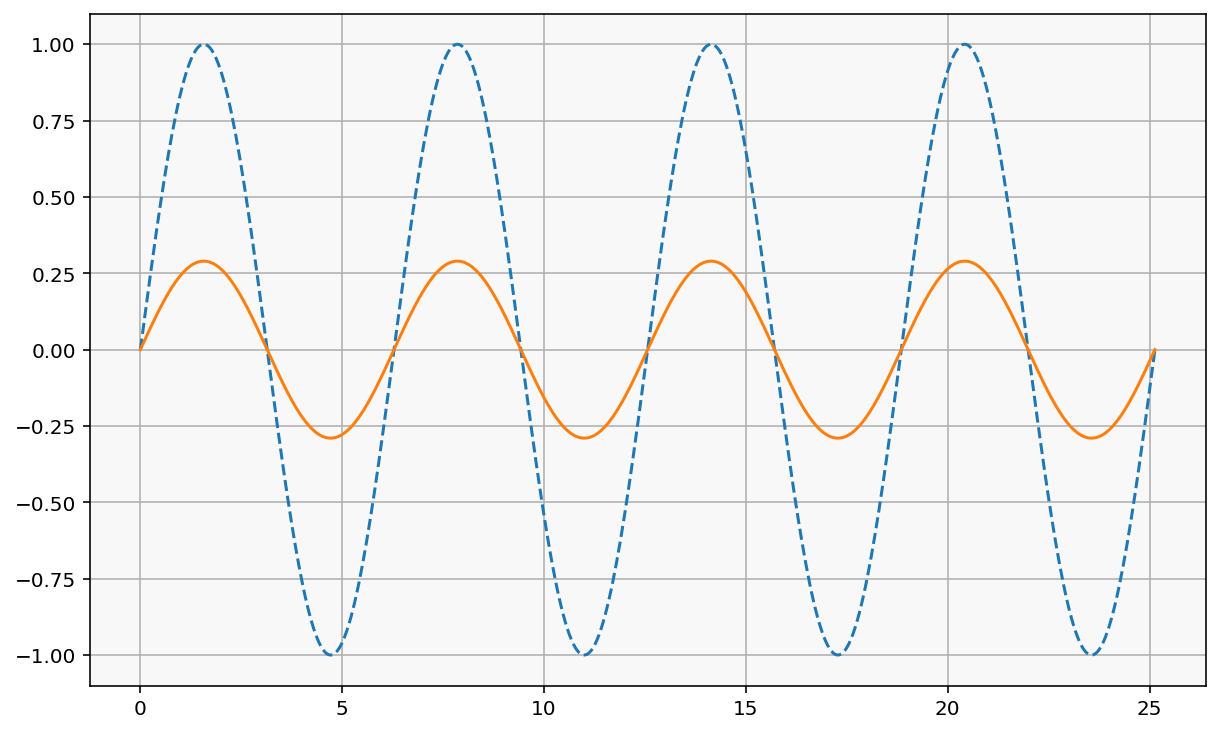

In [24]:
y = blur_np(x, steps)
plt.plot(t, x, '--')
plt.plot(t, y)

In [25]:
np_r = %timeit -o blur_np(x, steps)
t_np = np_r.best

15.7 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
times.append(t_np)
labels.append('numpy')

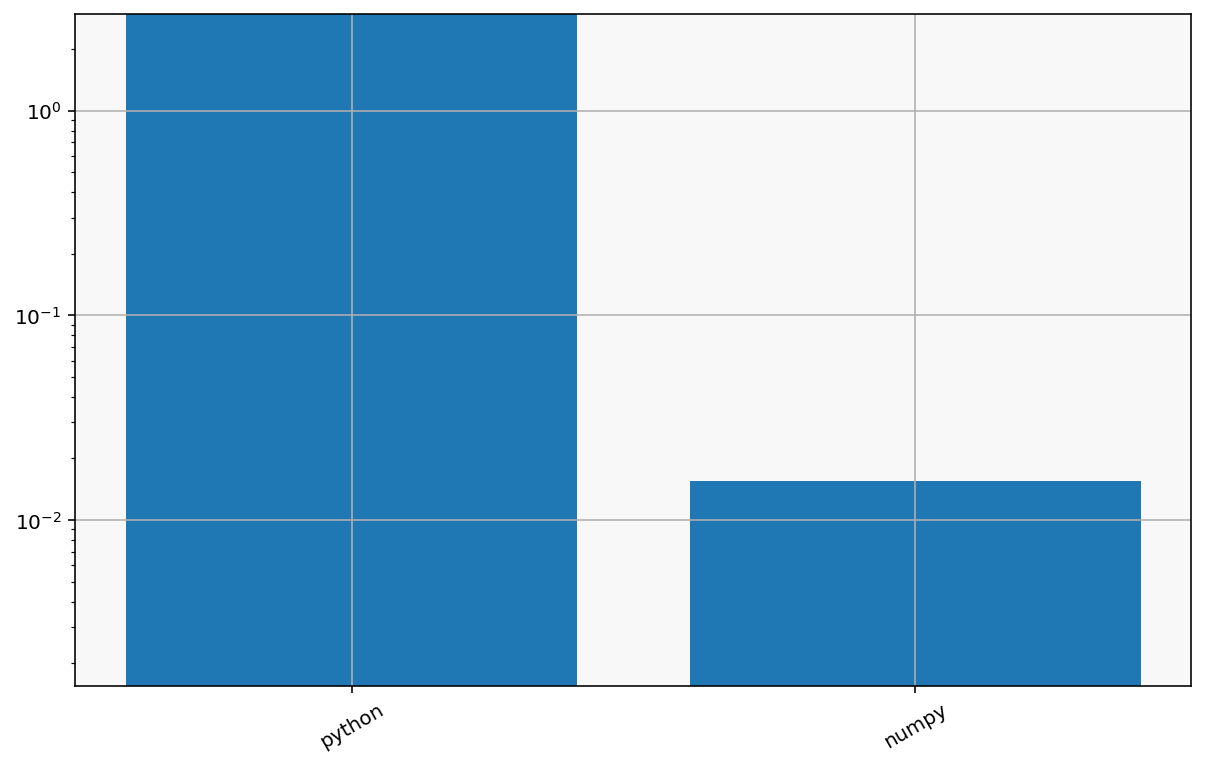

In [27]:
def plot_times():
    ind = np.arange(len(times))
    plt.bar(ind, times, log=True)
    plt.xticks(ind, labels, rotation=30)
    plt.ylim(0.1 * min(times), times[0])


plot_times()

So vectorizing the inner loop brings us from O(1 second) to O(10 milliseconds),
an improvement of ~100x:

In [28]:
t_ref / t_np

191.92856888852273

# Cython

[Cython](http://cython.org/) provides an IPython extension,
which defines a magic we can use to inline bits of Cython code in the notebook:

In [29]:
%load_ext Cython

In [30]:
%%cython

def csum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

In [31]:
%timeit csum(5)

777 ns ± 8.38 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


`%%cython --annotate` shows you annotations about the generated sourcecode.
The key to writing Cython is to minimize the amount of Python calls in the generated code. In general: yellow = slow.

In [32]:
def psum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

In [34]:
%%cython --annotate

def csum(n):
    cs = 0
    for i in range(n):
        cs += i
    return cs

Uh oh, that looks like a lot of yellow.
We can reduce it by adding some type annotations:

In [35]:
%%cython --annotate

def csum2(int n):
    cdef int i
    cs = 0
    for i in range(n):
        cs += i
    return cs

Almost there, but I still see yellow on the lines with `cs`:

In [36]:
%%cython --annotate

cpdef int csum3(int n):
    cdef int i
    cdef int cs = 0
    for i in range(n):
        cs += i
    return cs

Much better!
Now there's only Python when entering the function,
which is about as good as we can do.

In [37]:
N = 1_000_000
print('psum ', end=' ')
%timeit psum (N)
print('csum ', end=' ')
%timeit csum (N)
print('csum2', end=' ')
%timeit csum2(N)
print('csum3', end=' ')
%timeit csum3(N)

psum  560 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
csum  531 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
csum2 526 ms ± 5.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
csum3 288 ns ± 5.25 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Blurring with Cython

Now we can apply the same principles to writing a blur
in Cython.

In [38]:
%%cython --annotate

import numpy as np


def blur_cython(x, steps=1024):
    x = 1 * x  # copy
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x) - 1):
            x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
        x, x_k = x_k, x  # swap for next step
    return x

/Users/minrk/Library/Caches/ipython/cython/_cython_magic_092e2c612b671b8dcf66a75b44f1e675.c:2859:21: warning: fallthrough annotation in unreachable code [-Wunreachable-code-fallthrough]
                    CYTHON_FALLTHROUGH;
                    ^
/Users/minrk/Library/Caches/ipython/cython/_cython_magic_092e2c612b671b8dcf66a75b44f1e675.c:357:34: note: expanded from macro 'CYTHON_FALLTHROUGH'
      #define CYTHON_FALLTHROUGH __attribute__((fallthrough))
                                 ^
/Users/minrk/Library/Caches/ipython/cython/_cython_magic_092e2c612b671b8dcf66a75b44f1e675.c:2870:21: warning: fallthrough annotation in unreachable code [-Wunreachable-code-fallthrough]
                    CYTHON_FALLTHROUGH;
                    ^
/Users/minrk/Library/Caches/ipython/cython/_cython_magic_092e2c612b671b8dcf66a75b44f1e675.c:357:34: note: expanded from macro 'CYTHON_FALLTHROUGH'
      #define CYTHON_FALLTHROUGH __attribute__((fallthrough))
                                 ^
/Users/minrk/Lib

In [39]:
c1 = %timeit -o y = blur_cython(x, steps)
t_c1 = c1.best
times.append(t_c1)
labels.append("cython (no hints)")

2.91 s ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


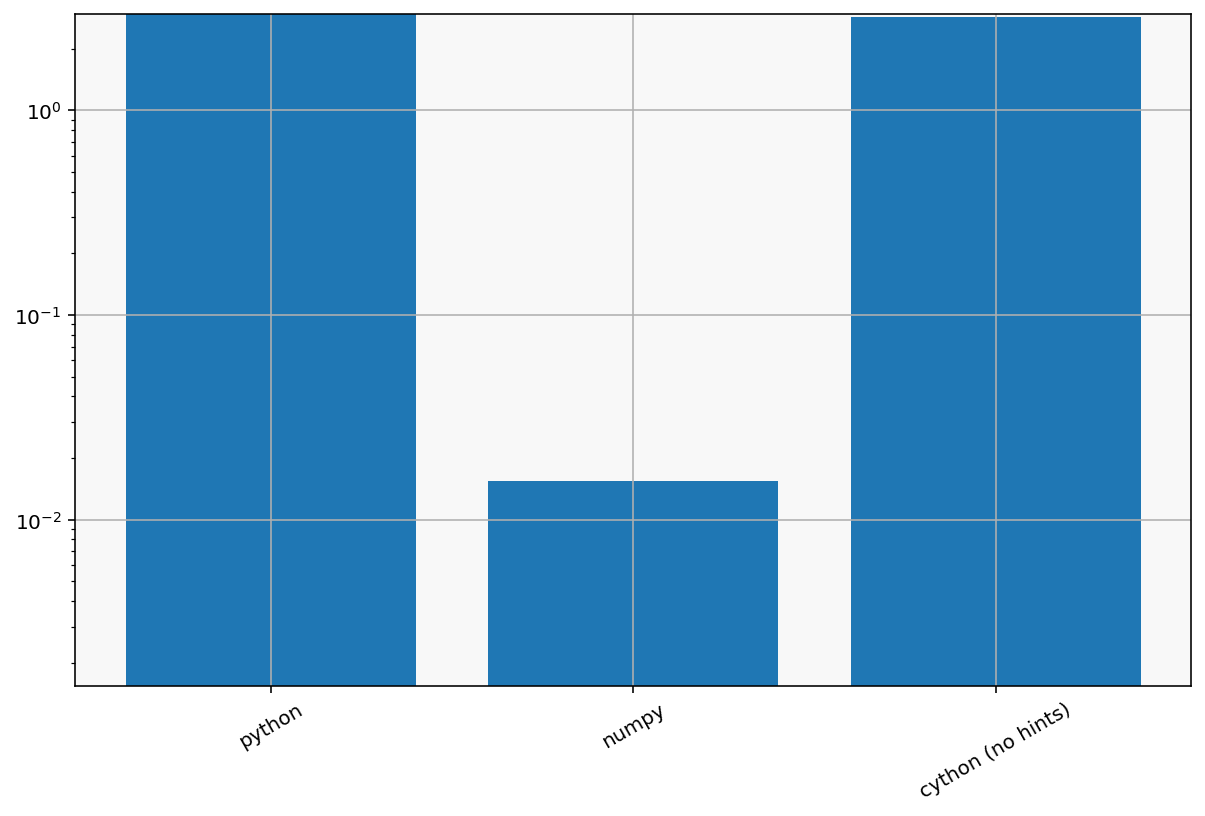

In [40]:
plot_times()

Without annotations, we don't get much improvement over the pure Python version.
We can note the types of the input arguments, to get some improvements:

In [50]:
%%cython --annotate

import numpy as np
cimport numpy as np

def blur_cython2(x, int steps=1024):
    x = 1 * x # copy
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    cdef int i, N = len(x)
    for _ in range(steps):
        for i in range(1, N-1):
            x_k[i] = .25 * ( x[i-1] + 2 * x[i] + x[i+1] )
        x, x_k = x_k, x # swap for next step
    return x

2.37 s ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


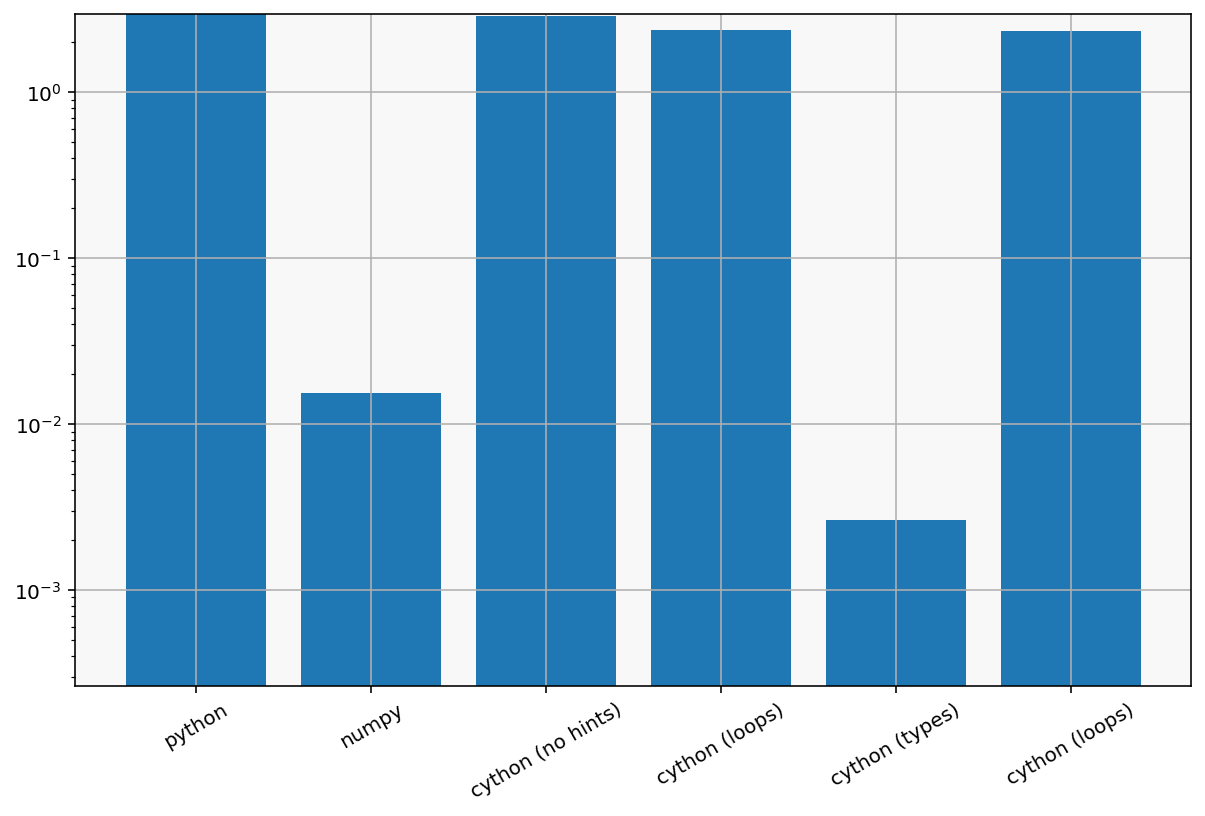

In [51]:
c2 = %timeit -o blur_cython2(x, steps)
t_c2 = c2.best
times.append(t_c2)
labels.append("cython (loops)")
plot_times()

Just by making sure the iteration variables are defined as integers, we can save about 25% of the time.

The biggest key to optimizing with Cython is getting that yellow out of your loops.
The more deeply nested a bit of code is within a loop,
the more often it is called, and the more value you can get out of making it fast.
In Cython, fast means avoiding Python (getting rid of yellow).
To get rid of Python calls, we need to tell Python about the numpy arrays `x` and `y`:


In [52]:
%%cython --annotate

import numpy as np
cimport numpy as np

def blur_cython_typed(np.ndarray[double, ndim=1] x_, int steps=1024):
    cdef size_t i, N = x_.shape[0]
    cdef np.ndarray[double, ndim=1] x
    cdef np.ndarray[double, ndim=1] x_k
    x = 1 * x_ # copy
    x_k = np.empty_like(x_)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, N - 1):
            x_k[i] = .25 * ( x[i - 1] + 2 * x[i] + x[i + 1] )
        x, x_k = x_k, x # swap for next step
    return x

2.61 ms ± 28.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


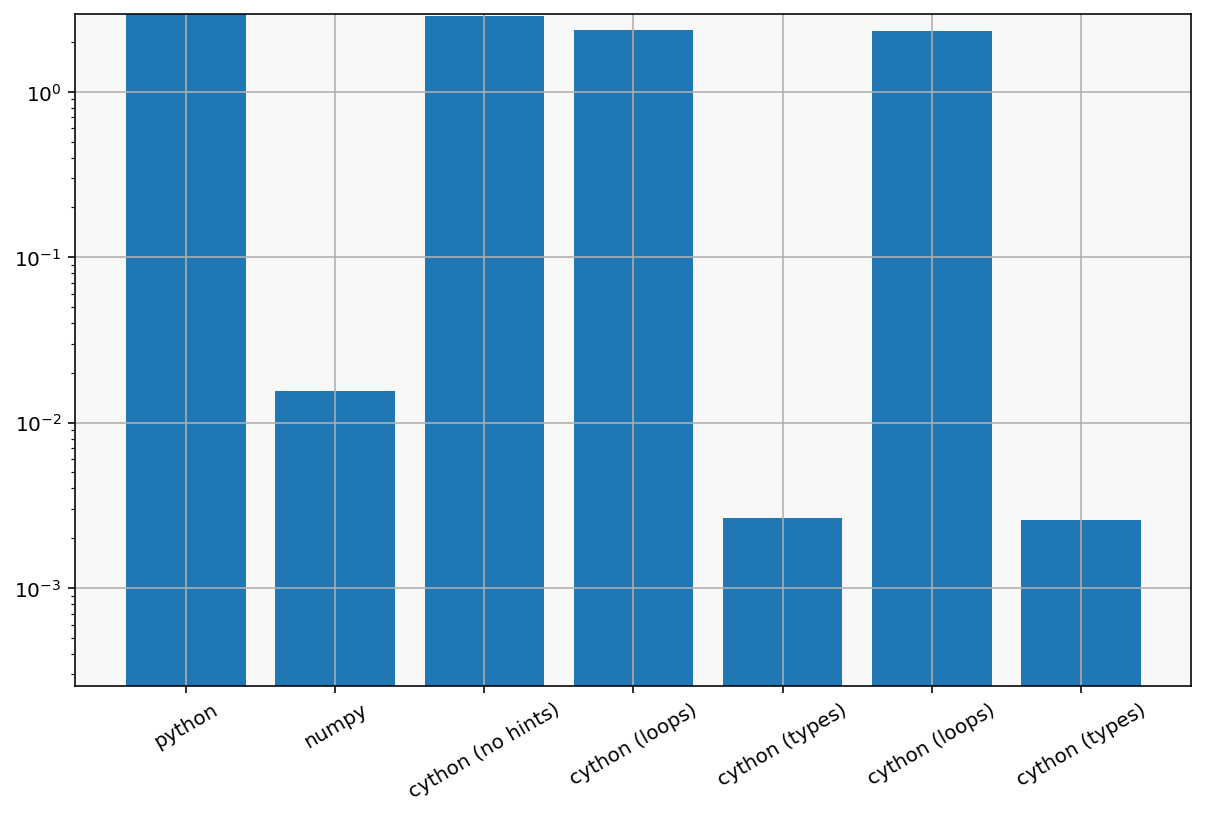

In [53]:
ct = %timeit -o y = blur_cython_typed(x, steps)
t_ct = ct.best

times.append(t_ct)
labels.append("cython (types)")
plot_times()

We can further optimize with Cython macros,
which disable bounds checking and negative indexing,
and avoiding the Python variable swaping by using indices into a single array:

In [54]:
x[len(x)]

IndexError: index 512 is out of bounds for axis 0 with size 512

In [55]:
%%cython --annotate

#cython: boundscheck=False
#cython: wraparound=False

import numpy as np
cimport numpy as np

def blur_cython_optimized(np.ndarray[double, ndim=1] x, size_t steps=1024):
    cdef size_t N = x.shape[0]
    cdef np.ndarray[double, ndim=2] X
    X = np.empty((2, N), dtype=np.float64)
    X[0, :] = x
    X[1, 0] = x[0]
    X[1, N - 1] = x[N - 1]
    
    cdef size_t _, i, j=0, k=1
    for _ in range(steps):
        j = _ % 2
        k = 1 - j
        for i in range(1, N - 1):
            X[k, i] = .25 * ( X[j, i - 1] + 2 * X[j, i] + X[j, i + 1] )
    return X[k]

Note how there is now zero yellow called in any of the loops,
only in the initial copy of the input array.

511 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


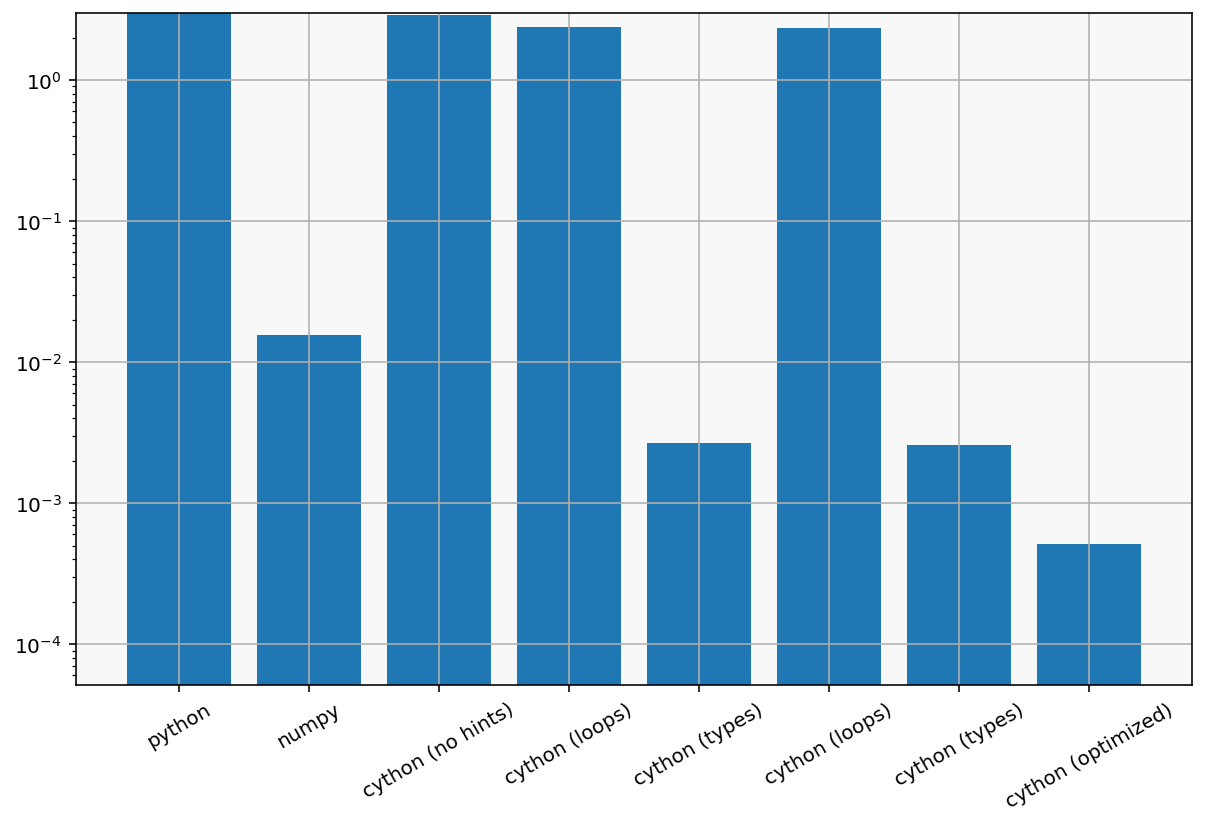

In [56]:
copt = %timeit -o y = blur_cython_optimized(x, steps)
t_copt = copt.best
times.append(t_copt)
labels.append("cython (optimized)")
plot_times()

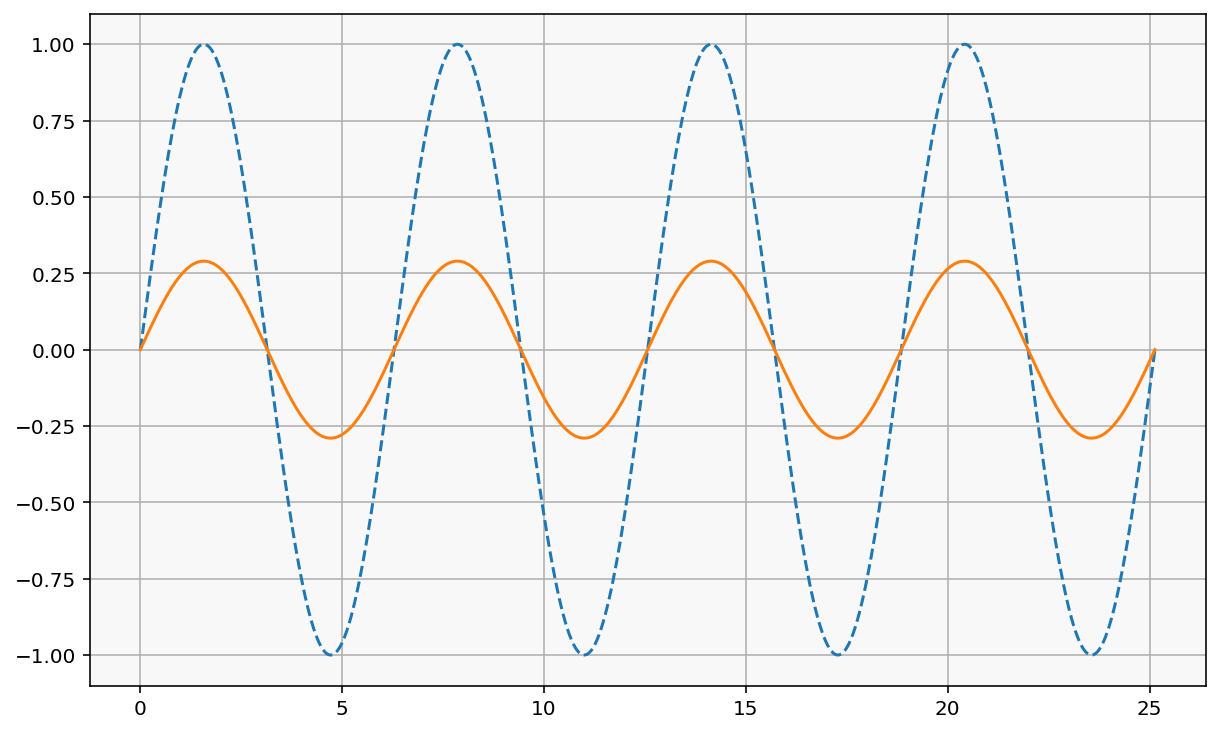

In [57]:
y = blur_cython_optimized(x, steps)
plt.plot(t, x, '--')
plt.plot(t, y)

## numba

[numba](http://numba.pydata.org/) is a library that attempts to automatically do type-based optimizations like we did with Cython.
To use numba, you decorate functions with `@autojit`.

In [58]:
import numba


@numba.jit
def blur_numba(x, steps=1024):
    """identical to blur_py, other than the decorator"""
    x = 1 * x  # copy
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x) - 1):
            x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
        x, x_k = x_k, x  # swap for next step
    return x


y = blur_numba(x, steps)

1.22 ms ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


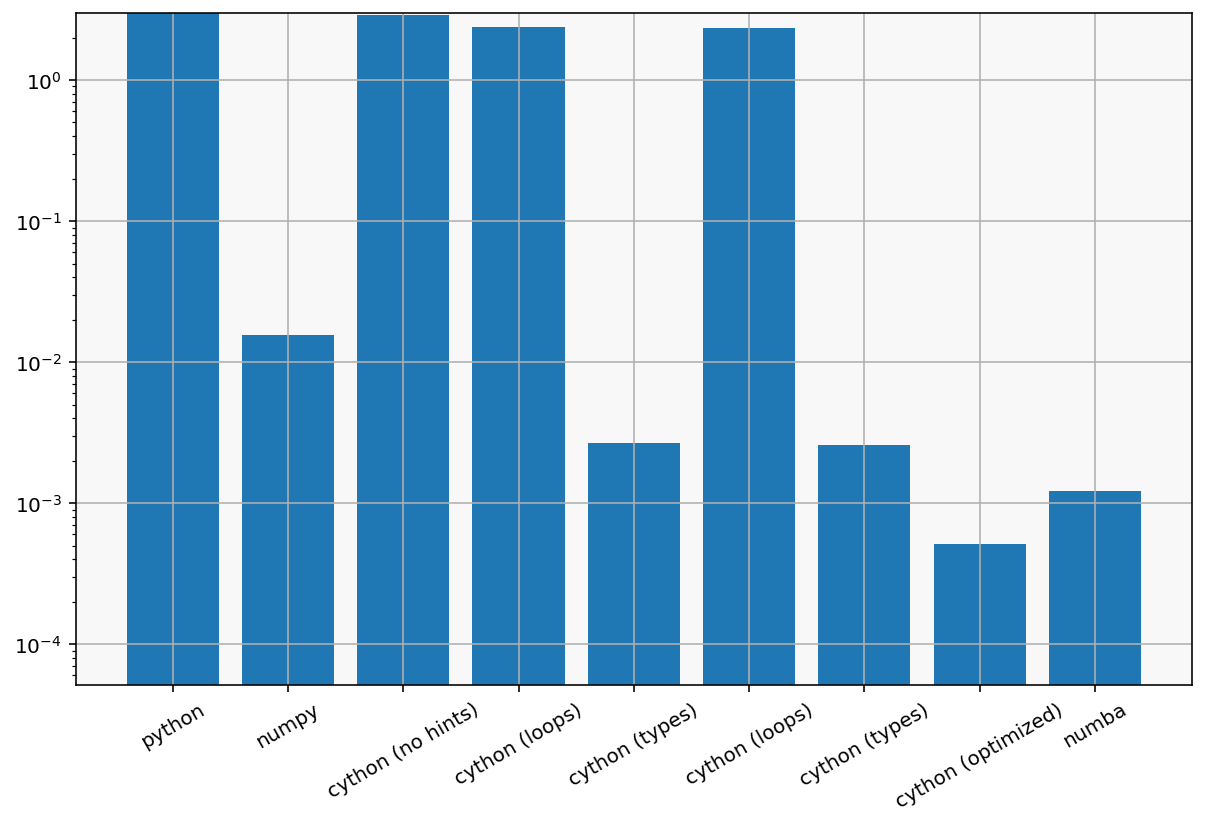

In [59]:
nb = %timeit -o blur_numba(x, steps)
t_nb = nb.best
times.append(t_nb)
labels.append("numba")
plot_times()

How did numba do that without any type info?

In [60]:
blur_numba.inspect_types()

blur_numba (array(float64, 1d, C), int64)
--------------------------------------------------------------------------------
# File: /var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/ipykernel_89709/2442902107.py
# --- LINE 4 --- 

@numba.jit

# --- LINE 5 --- 

def blur_numba(x, steps=1024):

    # --- LINE 6 --- 

    """identical to blur_py, other than the decorator"""

    # --- LINE 7 --- 
    # label 0
    #   x = arg(0, name=x)  :: array(float64, 1d, C)
    #   steps = arg(1, name=steps)  :: int64
    #   $const2.0 = const(int, 1)  :: Literal[int](1)
    #   del $const2.0
    #   x.1 = arrayexpr(expr=(<built-in function mul>, [const(int, 1), Var(x, 2442902107.py:7)]), ty=array(float64, 1d, C))  :: array(float64, 1d, C)
    #   del x
    #   x.1.2 = x.1  :: array(float64, 1d, C)

    x = 1 * x  # copy

    # --- LINE 8 --- 
    #   $10load_global.3 = global(np: <module 'numpy' from '/Users/minrk/conda/lib/python3.10/site-packages/numpy/__init__.py'>)  :: Module(<module 'numpy' from 

What's impressive about numba in this case
is that it is able to beat all but the most optimized of our implementations without any help.
Like Cython, numba can do an even better job when you provide it with more information about how a function will be called.

## Profiling

A script can be run with

```bash
python3 -m cProfile myscript.py
```

In [61]:
import sys

In [62]:
%prun list(os.walk(sys.prefix))

         2286954 function calls (1916720 primitive calls) in 6.833 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    44648    2.775    0.000    2.775    0.000 {built-in method posix.lstat}
   490088    1.516    0.000    1.516    0.000 {built-in method builtins.next}
414850/44616    0.958    0.000    6.782    0.000 os.py:344(_walk)
   445473    0.752    0.000    0.752    0.000 {method 'is_dir' of 'posix.DirEntry' objects}
    44615    0.422    0.000    0.422    0.000 {built-in method posix.scandir}
    44648    0.240    0.000    0.276    0.000 posixpath.py:71(join)
        1    0.052    0.052    6.833    6.833 <string>:1(<module>)
   445473    0.044    0.000    0.044    0.000 {method 'append' of 'list' objects}
    44615    0.021    0.000    0.021    0.000 {method '__exit__' of 'posix.ScandirIterator' objects}
    44648    0.016    0.000    2.793    0.000 posixpath.py:164(islink)
    44648    0.013    0.000    0.013    0.0

Snakeviz instaleld with:

    python3 -m pip install snakeviz

In [64]:
%load_ext snakeviz

In [65]:
%snakeviz -t blur_py(x, steps)

 
*** Profile stats marshalled to file '/var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/tmpzzbf0agi'.
Opening SnakeViz in a new tab...


404 GET /apple-touch-icon-precomposed.png (127.0.0.1) 2.93ms
404 GET /apple-touch-icon.png (127.0.0.1) 0.61ms


In [66]:
import hashlib

In [67]:
%%snakeviz -t
for dirpath, dirnames, filenames in os.walk('/usr/local'):
    for filename in filenames:
        if filename.endswith('.txt'):
            full_path = os.path.join(dirpath, filename)
            with open(full_path, 'rb') as f:
                hashlib.md5(f.read())

 
*** Profile stats marshalled to file '/var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/tmpres547vj'.
Opening SnakeViz in a new tab...


line_profiler installed with:

    python3 -m pip install line_profiler

In [68]:
%load_ext line_profiler

In [69]:
%lprun -f blur_py blur_py(x, steps)

Timer unit: 1e-06 s

Total time: 4.77519 s
File: /var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/ipykernel_89709/2340594174.py
Function: blur_py at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def blur_py(x0, steps=1024):
     2                                               """Advance a Gaussian blur `steps` steps"""
     3         1         53.0     53.0      0.0      x = 1 * x0  # copy
     4         1         25.0     25.0      0.0      x_k = np.empty_like(x)
     5         1          4.0      4.0      0.0      x_k[0] = x[0]
     6         1          1.0      1.0      0.0      x_k[-1] = x[-1]
     7      2049       2229.0      1.1      0.0      for k in range(steps):
     8   1046528    1005283.0      1.0     21.1          for i in range(1, len(x) - 1):
     9   1044480    3765803.0      3.6     78.9              x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
    10      2048       1780.0      0.9      0.0

In [70]:
%lprun -f blur_np blur_np(x, steps)

Timer unit: 1e-06 s

Total time: 0.032176 s
File: /var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/ipykernel_89709/109327557.py
Function: blur_np at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def blur_np(x, steps=1024):
     5         1        124.0    124.0      0.4      x = 1 * x
     6         1         57.0     57.0      0.2      x_k = np.empty_like(x)
     7         1         14.0     14.0      0.0      x_k[0] = x[0]
     8         1          5.0      5.0      0.0      x_k[-1] = x[-1]
     9      2049       3031.0      1.5      9.4      for _ in range(steps):
    10      2048      26011.0     12.7     80.8          x_k[1:-1] = 0.25 * (x[0:-2] + 2 * x[1:-1] + x[2:])
    11      2048       2917.0      1.4      9.1          x, x_k = x_k, x
    12         1         17.0     17.0      0.1      return x

In [71]:
%lprun -f blur_numba blur_numba(x, steps)

Timer unit: 1e-06 s

Total time: 0 s
File: /var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/ipykernel_89709/2442902107.py
Function: blur_numba at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           @numba.jit
     5                                           def blur_numba(x, steps=1024):
     6                                               """identical to blur_py, other than the decorator"""
     7                                               x = 1 * x  # copy
     8                                               x_k = np.empty_like(x)
     9                                               x_k[0] = x[0]
    10                                               x_k[-1] = x[-1]
    11                                               for _ in range(steps):
    12                                                   for i in range(1, len(x) - 1):
    13                                                       x_k[i] = 0.25 * (x[i - 1] + 2

In [72]:
%lprun -f blur_cython blur_cython(x, steps)

/Users/minrk/conda/lib/python3.10/site-packages/line_profiler/ipython_extension.py:71: UserWarning: Could not extract a code object for the object <built-in function blur_cython>
  profile = LineProfiler(*funcs)


Timer unit: 1e-06 s

In [77]:
%%cython --compile-args=-DCYTHON_TRACE=1

# cython: binding=True
# cython: linetrace=True

import numpy as np


def blur_cython_traced(x, steps=1024):
    x = 1 * x  # copy
    x_k = np.empty_like(x)
    x_k[0] = x[0]
    x_k[-1] = x[-1]
    for _ in range(steps):
        for i in range(1, len(x) - 1):
            x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
        x, x_k = x_k, x  # swap for next step
    return x

In [78]:
%lprun -f blur_cython_traced blur_cython_traced(x, steps)

Timer unit: 1e-06 s

Total time: 4.33147 s
File: /Users/minrk/Library/Caches/ipython/cython/_cython_magic_53aa39c9b2d885756f20d6c853a15022.pyx
Function: blur_cython_traced at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
     8                                           def blur_cython_traced(x, steps=1024):
     9         1         67.0     67.0      0.0      x = 1 * x  # copy
    10         1         42.0     42.0      0.0      x_k = np.empty_like(x)
    11         1          6.0      6.0      0.0      x_k[0] = x[0]
    12         1          5.0      5.0      0.0      x_k[-1] = x[-1]
    13      2049       1991.0      1.0      0.0      for _ in range(steps):
    14   1046528     897483.0      0.9     20.7          for i in range(1, len(x) - 1):
    15   1044480    3430378.0      3.3     79.2              x_k[i] = 0.25 * (x[i - 1] + 2 * x[i] + x[i + 1])
    16      2048       1496.0      0.7      0.0          x, x_k = x_k, x  # swap for next step
    17        

In [ ]:
%snakeviz -t np.dot(x, x)